### **Reading Data from kaggle**

In [56]:
#from google.colab import files
#files.upload()


In [2]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json


In [57]:
#!kaggle datasets download -d vaibhao/handwritten-characters


In [58]:
#!unzip handwritten-characters.zip -d data


### **Importing Libraries**

In [5]:
import numpy as np
import pandas as pd
import os
import random
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tqdm import tqdm

### **Reading Training and Validation  Data**

In [6]:
#========= Training ==========
dir = "/content/data/Train"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in tqdm(os.listdir(dir)):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 2000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

#========= Validation ==========
val_dir = "/content/data/Validation"
val_data = []
img_size = 32
for i in tqdm(os.listdir(val_dir)):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 500:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

100%|██████████| 39/39 [00:00<00:00, 54.40it/s]


In [7]:
print("Training samples:", len(train_data))
print("Validation samples:", len(val_data))

Training samples: 70000
Validation samples: 11209


In [8]:
# Get folder names only (ignore files)
folders = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f))]

# Remove unwanted folders
clean_folders = [f for f in folders if f not in non_chars]

print("Number of folders is :", len(clean_folders))
print("Folder Names :")
print(clean_folders)

Number of folders is : 35
Folder Names :
['Z', 'Q', 'Y', 'B', 'R', 'N', '8', 'V', 'S', 'J', '0', 'I', '5', '3', '6', '4', '1', 'T', 'L', 'G', 'X', 'E', '9', 'K', 'W', 'C', 'H', 'D', 'A', '2', '7', 'U', 'F', 'P', 'M']


### **Preparing Data For Model**

In [9]:
# Shuffle data to remove any ordering bias
random.shuffle(train_data)
random.shuffle(val_data)

# Separate features and labels for training data
X_train = [img for img, label in train_data]
y_train = [label for img, label in train_data]

# Separate features and labels for validation data
X_val = [img for img, label in val_data]
y_val = [label for img, label in val_data]

# Encode labels into one-hot vectors
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)

# Normalize pixel values (0–255 → 0–1)
X_train = np.array(X_train, dtype="float32") / 255.0
X_val = np.array(X_val, dtype="float32") / 255.0

# Reshape for CNN input (add channel dimension)
X_train = X_train.reshape(-1, 32, 32, 1)
X_val = X_val.reshape(-1, 32, 32, 1)

y_train = np.array(y_train)
y_val = np.array(y_val)

# Display final array shapes
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Training set: (70000, 32, 32, 1) (70000, 35)
Validation set: (11209, 32, 32, 1) (11209, 35)


### **CNN Model**

In [28]:

model = Sequential([
    Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(35, activation='softmax')
])


In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,851 (636.14 KB)

 Trainable params: 162,851 (636.14 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.optimizers import AdamW

model.compile(loss='categorical_crossentropy', optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),metrics=['accuracy'])

### **CallBacks**

In [31]:
early_stop = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True  )

In [32]:
checkpoint = ModelCheckpoint(filepath='best_model.keras',monitor='val_accuracy',save_best_only=True,mode='max',verbose=1)

### **Fitting Model**

In [33]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6140 - loss: 1.3178
Epoch 1: val_accuracy improved from -inf to 0.86734, saving model to best_model.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6141 - loss: 1.3175 - val_accuracy: 0.8673 - val_loss: 0.3879
Epoch 2/30
2177/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8573 - loss: 0.4334
Epoch 2: val_accuracy improved from 0.86734 to 0.89660, saving model to best_model.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8574 - loss: 0.4333 - val_accuracy: 0.8966 - val_loss: 0.3131
Epoch 3/30
2182/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8803 - loss: 0.3510
Epoch 3: val_accuracy did not improve from 0.89660
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8803 - loss: 0.3510 - val_accuracy: 0.8920 - val_loss: 0.3178
Epoch 4/30
2183/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8930 - loss: 0.3129
Epoch 4: val_accuracy improved from 0.89660 to 0.89785, saving m

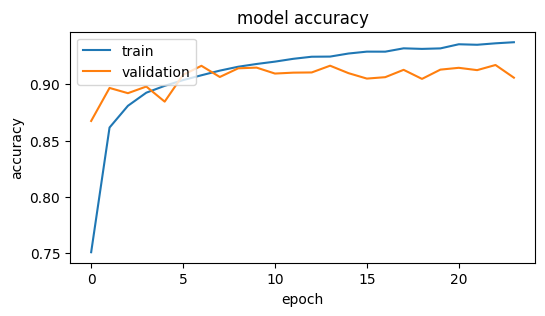

In [34]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

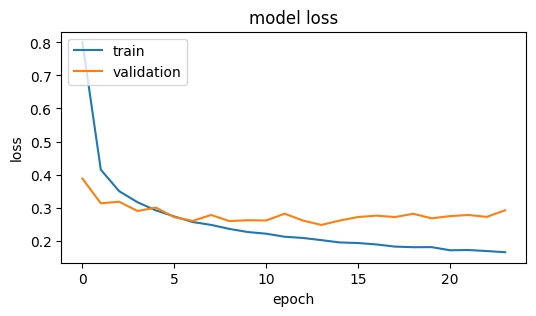

In [35]:
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Loading Best Model We trained**

In [36]:
from tensorflow.keras.models import load_model

# Load your best saved model
model = load_model('best_model.keras')

# Confirm it loaded
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,555 (1.86 MB)

 Trainable params: 162,851 (636.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 325,704 (1.24 MB)

In [37]:
def sort_contours(cnts, method="left-to-right"):
    # decide sorting direction
    reverse = method in ["right-to-left", "bottom-to-top"]
    sort_by_y = method in ["top-to-bottom", "bottom-to-top"]

    # get bounding box (x, y, w, h) for each contour
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]

    # choose index: 0 = x, 1 = y
    axis = 1 if sort_by_y else 0

    # sort both contours & boxes together
    cnts, bounding_boxes = zip(
        *sorted(zip(cnts, bounding_boxes),
                key=lambda b: b[1][axis],
                reverse=reverse)
    )

    return cnts, bounding_boxes


In [38]:
def get_letters(image_path):
    letters = []

    # Read and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold and dilate to highlight characters
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    binary = cv2.dilate(binary, None, iterations=2)

    # Find and sort contours (letters)
    contours = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]

    # Process each detected letter
    for c in contours:
        if cv2.contourArea(c) < 10:
            continue  # skip tiny noise

        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Crop the letter and preprocess
        roi = gray[y:y + h, x:x + w]
        roi = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        roi = cv2.resize(roi, (32, 32))
        roi = roi.astype("float32") / 255.0
        roi = roi.reshape(1, 32, 32, 1)

        # Predict the letter
        pred = model.predict(roi)
        letter = encoder.inverse_transform(pred)[0]
        letters.append(letter)

    return letters, img


In [39]:
def get_word(letter):
    word = "".join(letter)
    return word

### **Reading Test Data from Kaggle**

In [55]:
#from google.colab import files
#files.upload()


In [54]:
#!kaggle datasets download -d landlord/handwriting-recognition
#!unzip handwriting-recognition.zip -d /content/data/


In [53]:
#!ls /content/data/handwriting-recognition


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
HHB9NN7


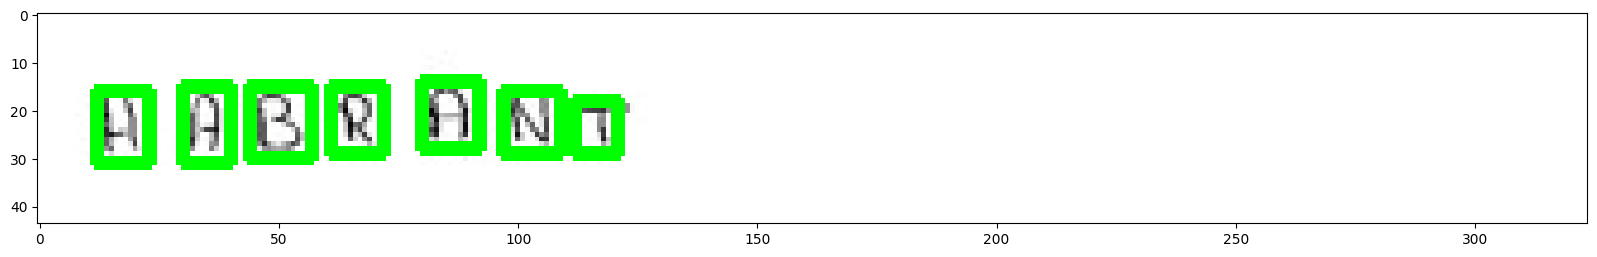

In [43]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
AYWFJC


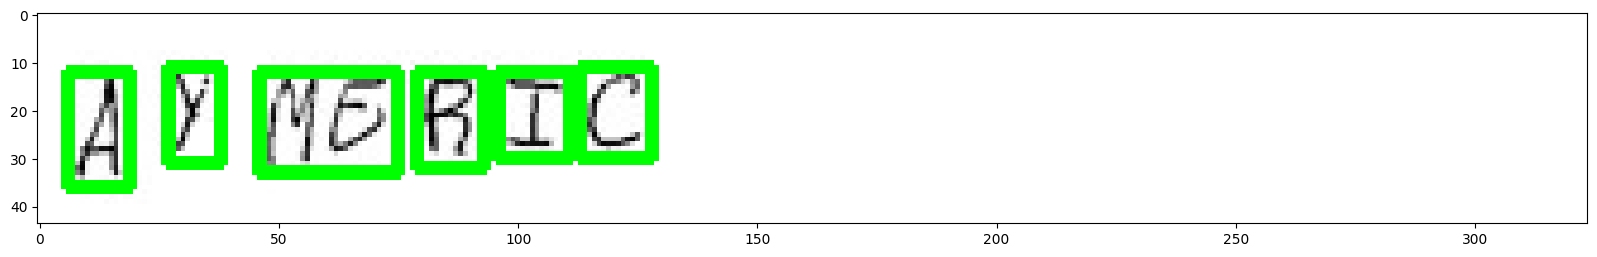

In [44]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
PHGH1A


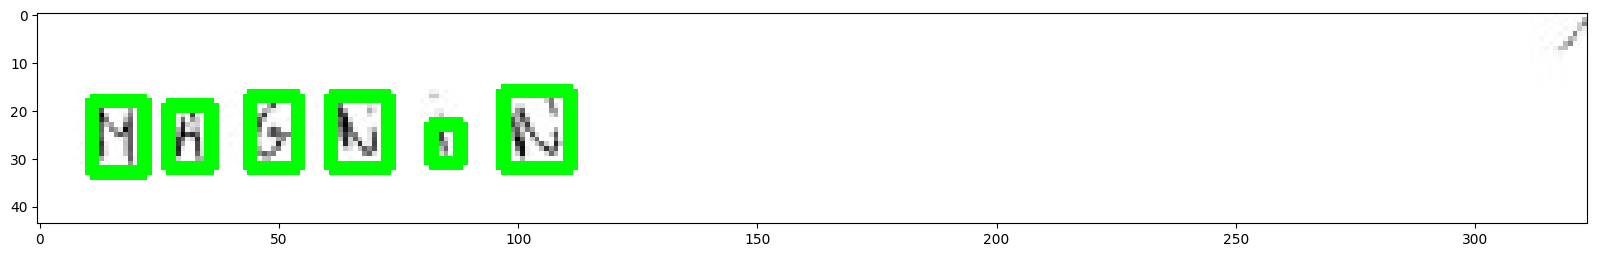

In [45]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
LLCN5


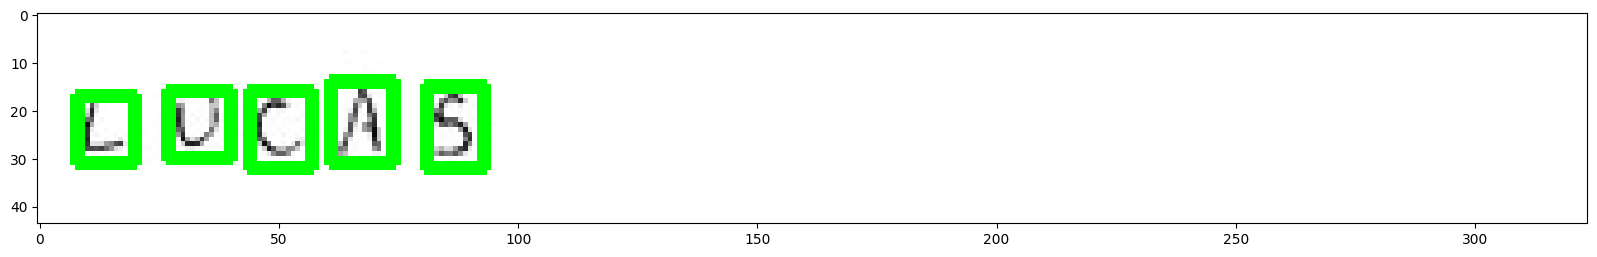

In [46]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
YCR0MA1N


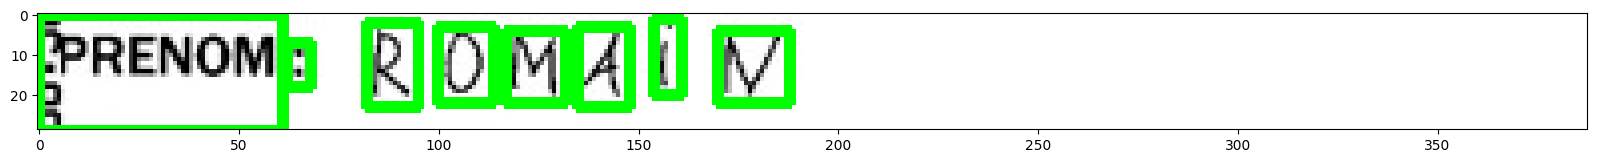

In [47]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
FWWNUNWNW


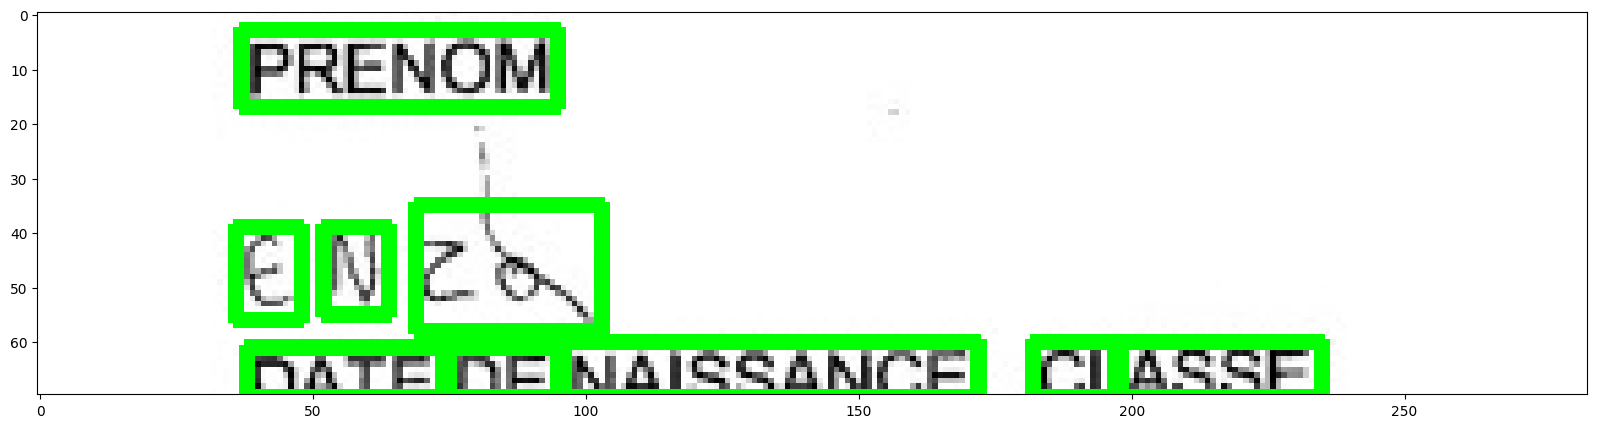

In [48]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
KYVERL4


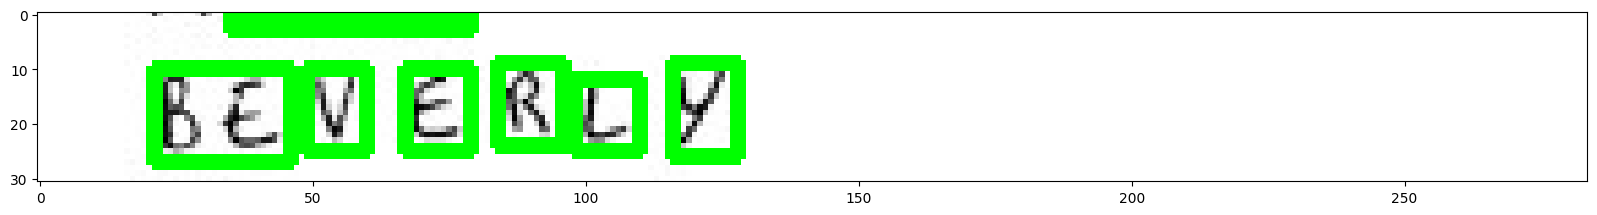

In [49]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
M2U9UHN


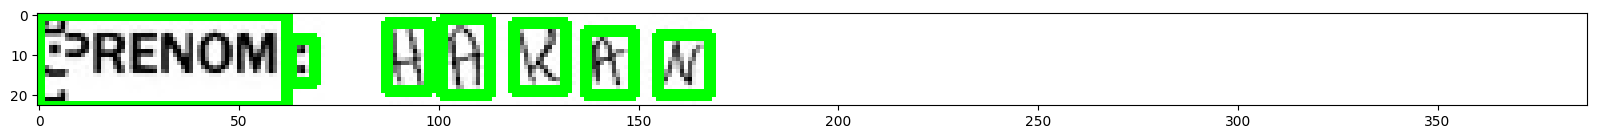

In [50]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SW2MTNYIY


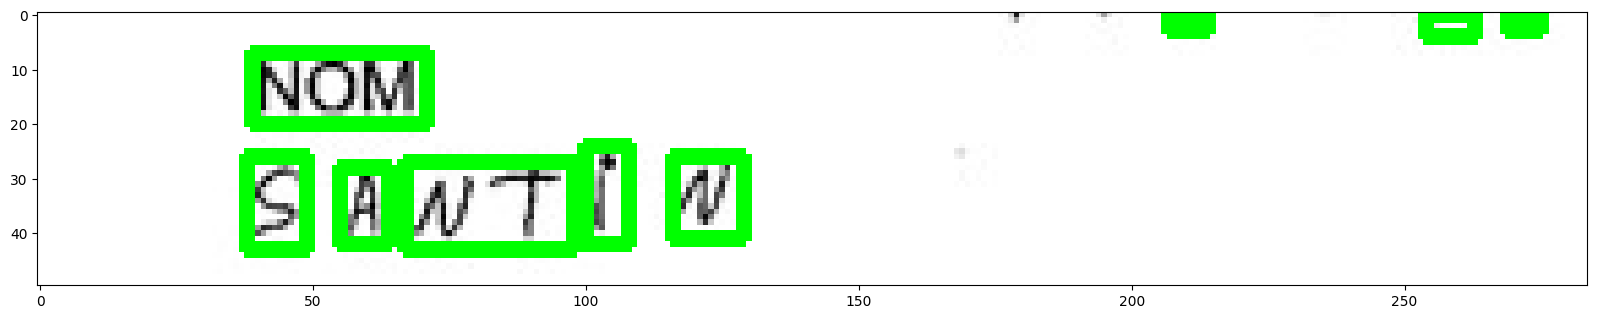

In [51]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
LYA4WCNE


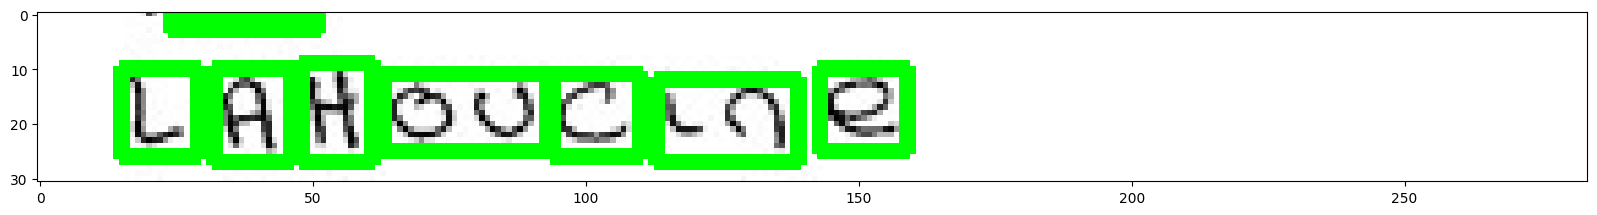

In [52]:
try :
    letter,image = get_letters(os.path.join("/content/data/test_v2/test", np.random.choice(os.listdir("/content/data/test_v2/test")) ))
    word = get_word(letter)
    print(word)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.imshow(image)
except :
    pass